In [1]:
import pandas as pd
from aeon.visualisation import plot_critical_difference

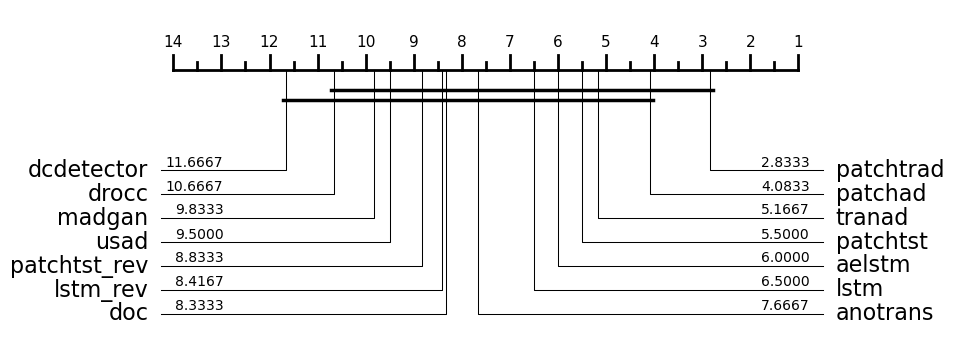

In [2]:
results = pd.read_json("results/aucs.json")
results = results.T
results = results[['aelstm', 'anotrans', 'patchtst', 'usad', 'lstm', 'tranad', 'patchtrad', 'patchad', 'madgan', 'drocc', 'lstm_rev', 'patchtst_rev', 'doc', 'dcdetector']]
methods = results.columns
plot = plot_critical_difference(results.values, methods, alpha=0.05, width=8, test='nemenyi')  

In [3]:
results = results.round(3).T
results["mean"] = results.mean(axis=1).round(3)
results

,nyc_taxi,ec2_request_latency_system_failure,msl,swat,smap,smd,mean
aelstm,0.664,0.998,0.589,0.840,0.614,0.828,0.756
anotrans,0.491,0.994,0.609,0.819,0.637,0.678,0.705
patchtst,0.696,0.999,0.560,0.843,0.514,0.882,0.749
usad,0.669,0.977,0.612,0.255,0.499,0.605,0.603
lstm,0.511,0.999,0.582,0.842,0.604,0.833,0.728
tranad,0.551,0.967,0.622,0.815,0.668,0.884,0.751
patchtrad,0.922,0.999,0.622,0.845,0.629,0.869,0.814
patchad,0.972,0.998,0.625,0.822,0.630,0.818,0.811
madgan,0.782,0.011,0.499,0.791,0.544,0.708,0.556
drocc,0.529,0.886,0.531,0.751,0.569,0.638,0.651


/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


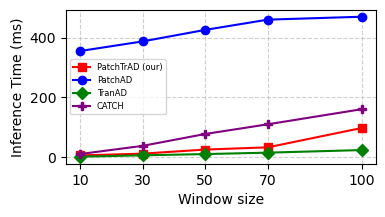

In [12]:
# Inference Speed for PatchAD, PatchTrAD, TranAD on the SWaT Dataset

import time
import torch
import matplotlib.pyplot as plt
import numpy as np

from models.patchad import PatchMLPAD
from models.patchtrad import PatchTrad
from models.tranad import TranAD
from models.catch import CATCHModel

import yaml
from types import SimpleNamespace

DEVICE="cuda"

wss = [10, 30, 50, 70, 100]
inference_times = {model: [] for model in ['PatchAD', 'PatchTrAD', 'TranAD', 'CATCH']}
for ws in wss:

    patchad_conf = yaml.safe_load(open("conf/dataset_model/patchad/swat.yaml"))
    patchad_conf["ws"]=ws
    patchad = PatchMLPAD(SimpleNamespace(**patchad_conf))
    patchtrad_conf = yaml.safe_load(open("conf/dataset_model/patchtrad/swat.yaml"))
    patchtrad_conf["ws"]=ws
    patchtrad = PatchTrad(SimpleNamespace(**patchtrad_conf))
    tranad_conf = yaml.safe_load(open("conf/dataset_model/tranad/swat.yaml"))
    tranad_conf["ws"]=ws
    tranad = TranAD(SimpleNamespace(**tranad_conf))
    catch_conf = yaml.safe_load(open("conf/dataset_model/catch/swat.yaml"))
    catch_conf["ws"]=ws
    catch = CATCHModel(SimpleNamespace(**catch_conf))


    x = torch.randn(128, ws, 51)

    models = {
        "PatchAD": patchad,
        "PatchTrAD": patchtrad,
        "TranAD": tranad,
        "CATCH": catch}

    def measure_inference_speed(model, x, device="cuda", runs=50):
        x = x.to(device)
        model = model.to(device)
        model.eval()
        
        if model == models['TranAD']: 
            # Warm-up
            input = x.permute(1, 0, 2)
            elem = input[-1, :, :].view(1, input.size(1), input.size(2))
            with torch.no_grad():
                for _ in range(10):
                    _ = model(input, elem)
            
            # Measure inference time
            times = []
            with torch.no_grad():
                for _ in range(runs):
                    start = time.time()
                    _ = model(input, elem)
                    end = time.time()
                    times.append(end - start)

        else:
            # Warm-up
            with torch.no_grad():
                for _ in range(10):
                    _ = model(x)
            
            # Measure inference time
            times = []
            with torch.no_grad():
                for _ in range(runs):
                    start = time.time()
                    _ = model(x)
                    end = time.time()
                    times.append(end - start)
        
        avg_time = np.mean(times) * 1000  
        model = model.cpu()
        return avg_time

    
    for name, model in models.items():
        inference_times[name].append(measure_inference_speed(model, x))

inference_times = {k: v for k, v in zip(['PatchTrAD', 'PatchAD', 'TranAD', 'CATCH'], [inference_times['PatchTrAD'], inference_times['PatchAD'], inference_times['TranAD'], inference_times['CATCH']])}

col = {
    "PatchAD": "blue",
    "PatchTrAD": "red",
    "TranAD": "green",
    "CATCH": "purple"
}
markers = {
    "PatchAD": "o",
    "PatchTrAD": "s",
    "TranAD": "D",
    "CATCH": "P"
}

plt.figure(figsize=(4, 2))

for name, values in inference_times.items():
    # different color and linestyle for each model
    plt.plot(wss, values, label=name+" (our)" if name=="PatchTrAD" else name, color=col[name], linestyle='-', marker=markers[name])
# patchtrad above in legend
plt.legend(fontsize=6)
plt.xticks(wss) 
plt.xlabel("Window size")
plt.ylabel("Inference Time (ms)")
#plt.title("Inference Speed Comparison based on SWaT Dataset configuration for multiple window size")
plt.grid(True, linestyle="--", alpha=0.6)
#plt.savefig("infspeed.png", bbox_inches="tight")